In [1]:
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt

<Axes: >

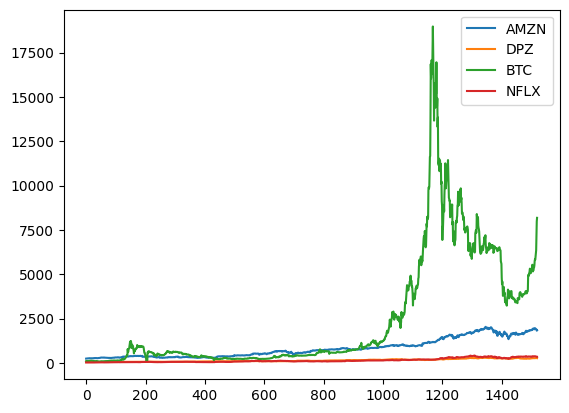

In [2]:
df = pd.read_csv('portfolio_data.csv')
df.plot()

<Axes: >

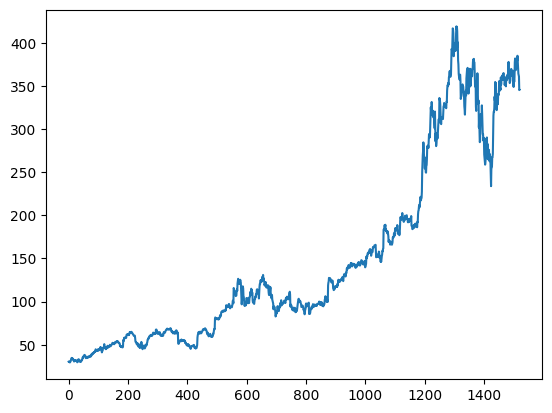

In [3]:
df_nflx = df['NFLX']
df_nflx.plot()

<Axes: >

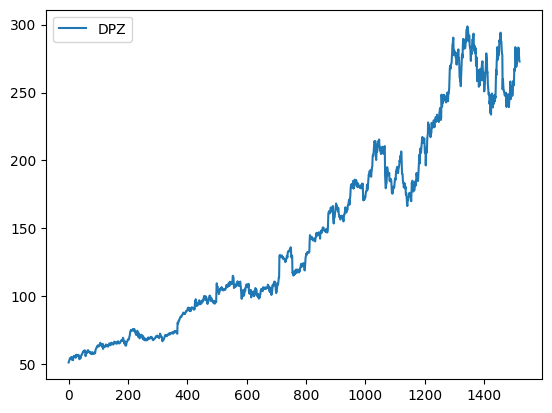

In [4]:
df_dpz = df[['DPZ']]
df_dpz.plot()

In [5]:
def generate_time_lags(df, n_lags):
    df_n = df.copy()
    for n in range(1, n_lags + 1):
        df_n[f"lag{n}"] = df_n['DPZ'].shift(-n)
    df_n = df_n.iloc[:-n_lags]
    return df_n
    
input_dim = 1

df_generated = generate_time_lags(df_dpz, input_dim)
df_generated

,DPZ,lag1
0,51.190983,51.987320
1,51.987320,52.446388
2,52.446388,53.205257
3,53.205257,54.151505
4,54.151505,54.385727
...,...,...
1514,277.390015,283.149994
1515,283.149994,282.160004
1516,282.160004,278.369995
1517,278.369995,273.880005


In [6]:
from sklearn.model_selection import train_test_split

def feature_label_split(df, target_col):
    y = df[[target_col]]
    X = df.drop(columns=[target_col])
    return X, y

def train_val_test_split(df, target_col, test_ratio):
    val_ratio = test_ratio / (1 - test_ratio)
    X, y = feature_label_split(df, target_col)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, shuffle=False)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_ratio, shuffle=False)
    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(df_generated, 'lag1', 0.2)    

In [7]:
from torch.utils.data import TensorDataset, DataLoader

train = TensorDataset(torch.Tensor(X_train.values), torch.Tensor(y_train.values))
val = TensorDataset(torch.Tensor(X_val.values), torch.Tensor(y_val.values))
test = TensorDataset(torch.Tensor(X_test.values),torch.Tensor(y_test.values))

train_loader = DataLoader(train)
val_loader = DataLoader(val)
test_loader = DataLoader(test)

In [8]:
import torch.optim as optim
from GRU import *

input_dim = len(X_train.columns)
output_dim = 1
hidden_dim = 64
layer_dim = 3
n_epochs = 100
learning_rate = 1e-3
weight_decay = 1e-6

model_params = {'input_dim': input_dim,
                'output_dim' : output_dim,
                'hidden_dim' : hidden_dim,
                'n_layers' : layer_dim,
                }

model = StockGRU(**model_params)

loss_fn = torch.nn.MSELoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_loader, val_loader, n_epochs=n_epochs, n_features=input_dim)
# opt.plot_losses()

predictions, values = opt.evaluate(test_loader=test_loader, batch_size=1, n_features=input_dim)


[1/100] Training loss: 3910.4209	 Validation loss: 14324.2091
[2/100] Training loss: 880.5177	 Validation loss: 8596.0597
[3/100] Training loss: 736.2598	 Validation loss: 6776.3149
[4/100] Training loss: 702.0622	 Validation loss: 5698.9305
[5/100] Training loss: 558.9077	 Validation loss: 5003.9876
[6/100] Training loss: 531.4940	 Validation loss: 4351.3561
[7/100] Training loss: 637.9127	 Validation loss: 4306.4498
[8/100] Training loss: 551.2555	 Validation loss: 4074.5130
[9/100] Training loss: 568.1942	 Validation loss: 3898.2891
[10/100] Training loss: 567.5801	 Validation loss: 3906.8915
[50/100] Training loss: 506.0455	 Validation loss: 2570.6849
[100/100] Training loss: 668.7461	 Validation loss: 3589.9654


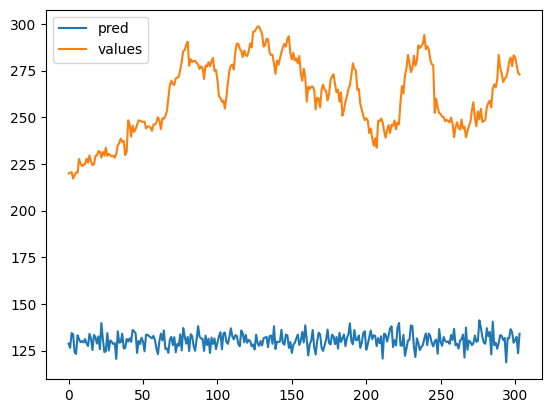

In [34]:
plt.plot(predictions,label='pred')
plt.plot(values,label='values')
plt.legend()
plt.show()

<Axes: >

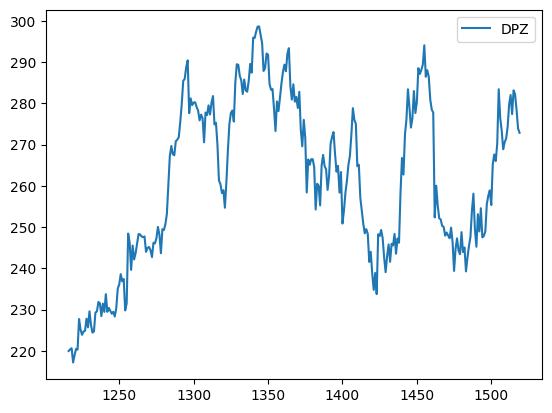

In [36]:
df_dpz.iloc[int(len(df_dpz.values)*0.8):].plot()